In [61]:
import pandas as pd
import pickle
import missingno as msn
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

In [2]:
df1 = pd.read_csv('data\ga_sessions.csv', low_memory=False)
df1.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [3]:
df2 = pd.read_csv('data\ga_hits.csv')
df2.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [4]:
#извлекаем целевые действия из таблицы 2 и добавляем в таблицу 1
t_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

target_sessions = list(df2[df2.event_action.isin(t_actions)].session_id.unique())

def target(data):
    return int(data in target_sessions)
    

df1['target'] = df1.session_id.isin(target_sessions)
df1['target'] = df1.target.astype(int)
df1.sample(15)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
715028,3951932833839319116.1630668878.1630668878,920131065.1630668876,2021-09-03,14:00:00,1,IZEXUFLARCUMynmHNBGo,blogger_channel,ngkgBNjlzLYBofkljaBo,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Xiaomi,NaN,393x851,Chrome,Russia,Saint Petersburg,0
912264,4832017159452757793.1640369953.1640369953,1125041665.1640369953,2021-12-24,21:19:13,1,TTtiRKFZIaQpIWggfCoF,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x812,Safari,United States,Forest City,0
635015,3593442023994953565.1630408542.1630408542,836663419.1630408541,2021-08-31,14:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,NaN,NaN,NaN,1920x1080,YaBrowser,Russia,Moscow,0
515482,3058351487614694142.1636830901.1636830901,712077945.1636807422,2021-11-13,22:15:01,2,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,COtBsnAzfZyRVtvDlhnW,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Moscow,0
131435,1342421012442306636.1638193244.1638193244,312556748.1638193228,2021-11-29,16:40:44,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,jpZoxCaowxXvglZVUJyq,mobile,Android,(not set),AuMdmADEIoPXiWpTsBEj,320x570,Android Webview,Russia,Saint Petersburg,0
1435996,7167487681996154632.1634177452.1634177452,1668810770.1633576712,2021-10-14,05:00:00,8,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,desktop,NaN,NaN,NaN,1280x720,Chrome,Russia,Krasnodar,0
1643971,8092489510012196703.1624905621.1624905621,1884179541.1624905567,2021-06-28,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,WiILFRDQbcHDHNvHzGpX,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,Chrome,Russia,Moscow,0
1588268,7843087055569925478.1639298405.1639298405,1826111007.1639298406,2021-12-12,11:40:05,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,414x736,Safari,Russia,Tuymazy,0
1463358,7288019750104391480.1627447097.1627447097,1696874329.1627447096,2021-07-28,07:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x667,Safari,Russia,Moscow,0
528808,3119643458351946623.1626364801.1626364801,726348594.1626364799,2021-07-15,19:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,mIKayglJaKQZvgdtLfqT,NaN,NaN,desktop,NaN,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0


In [5]:
df1.target.value_counts(dropna=False)

0    1809728
1      50314
Name: target, dtype: int64

сессий с целевым действием - 50314, без целевого действия - 1809728

In [6]:
df1.to_csv('data\ga_sessions_target.csv', index=False)

# Data Preparation

In [7]:
df = pd.read_csv('data\ga_sessions_target.csv', low_memory=False)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [8]:
df.shape

(1860042, 19)

In [9]:
#проверяем наличие дублирующихся строк
df[df.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target


##дубликаты отсутствуют

In [10]:
#изучение датафрейма на предмет полноты заполнения строк
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1860042 non-null  object
 1   client_id                 1860042 non-null  object
 2   visit_date                1860042 non-null  object
 3   visit_time                1860042 non-null  object
 4   visit_number              1860042 non-null  int64 
 5   utm_source                1859945 non-null  object
 6   utm_medium                1860042 non-null  object
 7   utm_campaign              1640439 non-null  object
 8   utm_adcontent             1524427 non-null  object
 9   utm_keyword               777981 non-null   object
 10  device_category           1860042 non-null  object
 11  device_os                 789904 non-null   object
 12  device_brand              1492864 non-null  object
 13  device_model              16338 non-null  

In [11]:
#преобразуем столбец visit_date в формат даты
df.visit_date = pd.to_datetime(df.visit_date, utc=True)

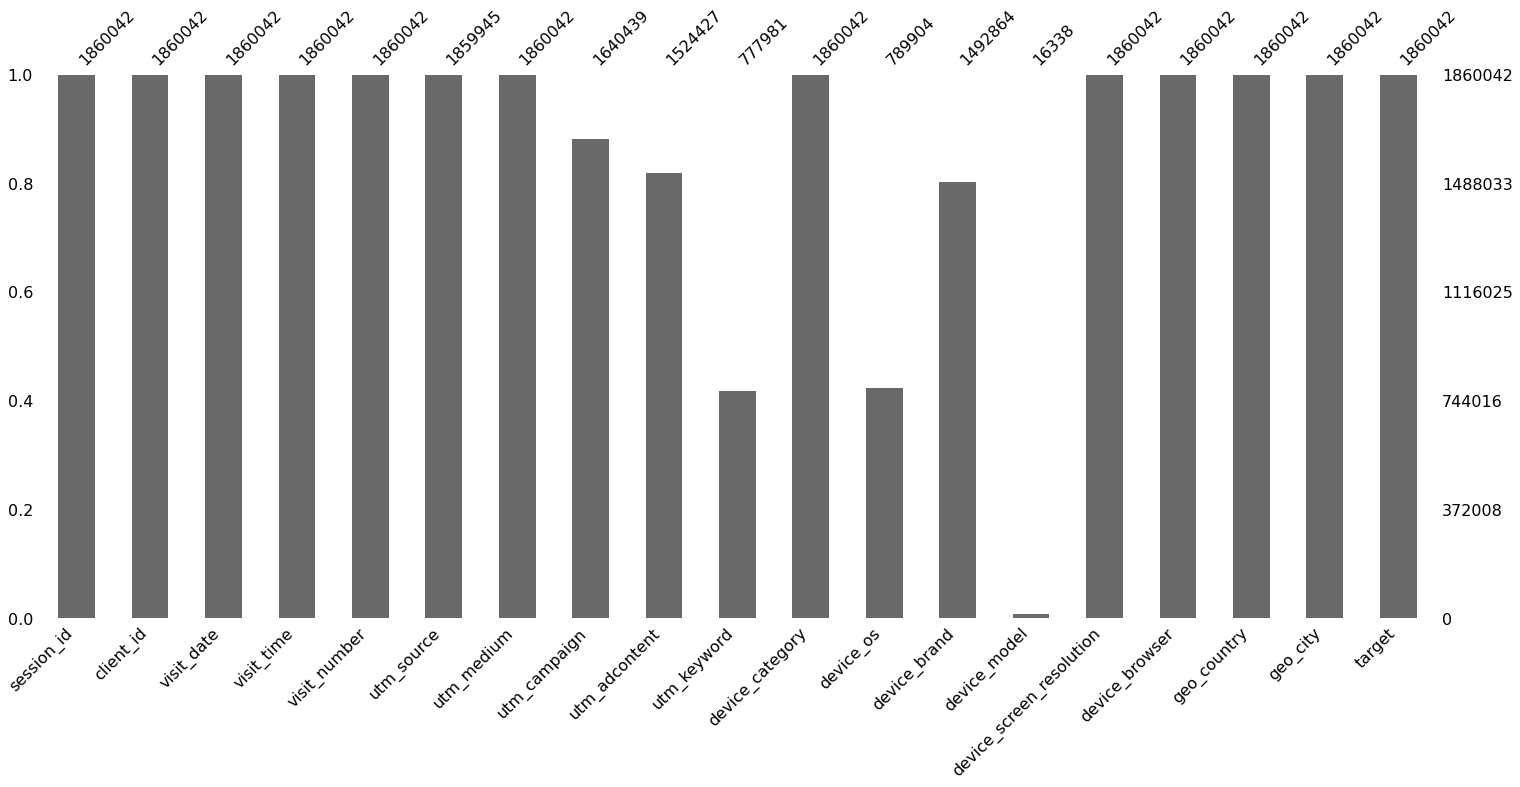

In [12]:
#исследуем столбцы на полноту заполненности
msn.bar(df);

In [13]:
#выведем процент незаполненных значений
missing_values = ((df.isna().sum()/len(df))*100).sort_values()
missing_values

session_id                   0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_city                     0.000000
target                       0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
utm_medium                   0.000000
utm_source                   0.005215
utm_campaign                11.806346
utm_adcontent               18.043410
device_brand                19.740307
device_os                   57.533002
utm_keyword                 58.174009
device_model                99.121633
dtype: float64

In [14]:
df_clean = df.copy()

#удаляем графы device_model, device_os, utm_keyword, т.к. они содержат менее половины заполненных значений
df_clean = df_clean.drop('device_model', axis = 1)
df_clean = df_clean.drop('device_os', axis = 1)
df_clean = df_clean.drop('utm_keyword', axis = 1)

df_clean.shape

(1860042, 16)

In [15]:
#исследуем парамерт utm_adcontent
df_clean.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
                         ...   
vXARZToVDdvNhALiQtvl          1
ryswqHdLvbezpDLjokYF          1
gQEnaeQmOHisHSTEyzhp          1
PlanrlymnpCeYvUrUTVJ          1
oJivRDNIrrOckRBIKOtG          1
Name: utm_adcontent, Length: 287, dtype: int64

In [16]:
#В связи с большим количеством пропущенных значений, заполним их показателем Other. Все значения с долей менее 1% также отнесем в эту категорию
df_clean.utm_adcontent = df_clean.utm_adcontent.fillna('Other_adcont')
utm_adcontent_list = list(df_clean.utm_adcontent.value_counts(dropna=False, normalize=True)[df_clean.utm_adcontent.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.3f}') >= '0.01'].index)

def utm_adcontent_freq(data):
    if data in utm_adcontent_list:
        return data
    return 'Other_adcont'

df_clean['utm_adcontent'] = df_clean.utm_adcontent.apply(utm_adcontent_freq)
df_clean.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    1006599
Other_adcont             456596
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
Name: utm_adcontent, dtype: int64

In [17]:
#исследуем парамерт utm_campaign
df_clean.utm_campaign.value_counts(dropna=False)

LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
                         ...  
RkpOyeEPgcMBSDuHLQcj         1
pcvPxfVFaAmhwFmvIeYd         1
qPDTdivQVeflLjTYIJnG         1
MHdHrBKQwbDaRalwnlJq         1
cXxuwXPoQCvAXPHpFcZl         1
Name: utm_campaign, Length: 413, dtype: int64

In [18]:
#В связи с большим количеством пропущенных значений, заполним их показателем Other. Все значения с долей менее 1% также отнесем в эту категорию
df_clean.utm_campaign = df_clean.utm_campaign.fillna('Other_campaign')
utm_campaign_list = list(df_clean.utm_campaign.value_counts(dropna=False, normalize=True)[df_clean.utm_campaign.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.3f}') >= '0.01'].index)

def utm_campaign_freq(data):
    if data in utm_campaign_list:
        return data
    return 'Other_campaign'

df_clean['utm_campaign'] = df_clean.utm_campaign.apply(utm_campaign_freq)
df_clean.utm_campaign.value_counts(dropna=False)

Other_campaign          572454
LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
Name: utm_campaign, dtype: int64

In [19]:
#Проверим соотношение брендов в разрезе категорий девайсов
category_list = list(df_clean.device_category.unique())
for item in category_list:
    print(item,'\n',df_clean[df_clean['device_category'] == item].device_brand.value_counts(dropna=False),'\n')


mobile 
 Apple        544793
Samsung      327231
Xiaomi       288115
Huawei       182393
Realme        19049
              ...  
KingSing          1
Honeywell         1
myPhone           1
Orbic             1
Evercoss          1
Name: device_brand, Length: 175, dtype: int64 

tablet 
 Apple           6223
Samsung         4955
Huawei          3441
Lenovo          1656
Google           713
                ... 
ZTE                1
Dragon Touch       1
Tanix              1
Nomu               1
Explay             1
Name: device_brand, Length: 74, dtype: int64 

desktop 
 NaN          366721
Apple            72
Huawei           19
Xiaomi           10
(not set)        10
Samsung           8
Realme            5
Google            4
OPPO              4
Flexymove         3
Beelink           2
OnePlus           2
Nokia             1
Asus              1
Philips           1
Name: device_brand, dtype: int64 



##десктопные устройства преимущественно не содержат наименования бренда

In [20]:
#заменим отсутствующие значения на моду по категории, при этом в категории desktop обозначим в качестве бренда desktop
brand_dict = {i : df_clean[df_clean['device_category'] == i]['device_brand'].mode(dropna=False)[0] for i in category_list}
brand_dict['desktop'] = 'desktop'
df_clean['device_brand'] = df_clean['device_brand'].fillna(df_clean.device_category.map(brand_dict))

In [21]:
df_clean.device_brand.isna().sum()

0

# Feature Inginiring

In [22]:
#создадим фичу, сочетающую в себе категорию девайса и его модель (при наличии) 
def device_comby(category, brand):
    if brand == '':
        return str(category)
    return str(category) + '-' + str(brand)

df_clean['device+brand'] = df_clean.apply(lambda x: device_comby(x['device_category'], x['device_brand']), axis=1)
df_clean.sample(15)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,device+brand
331120,2238928408211449241.1626957210.1626957210,521291142.1626957209,2021-07-22 00:00:00+00:00,15:00:00,1,gDBGzjFKYabGgSPZvrDH,cpm,FTjNLDyTrXaWYgZymFkV,Other_adcont,desktop,desktop,1536x864,Chrome,Russia,(not set),0,desktop-desktop
900702,4780380249413791964.1637495016.1637495016,1113019010.1637495004,2021-11-21 00:00:00+00:00,14:43:36,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,tablet,Huawei,960x600,Chrome,Russia,Moscow,0,tablet-Huawei
944906,4975422814627684827.1631707613.1631707613,1158430896.1631707611,2021-09-15 00:00:00+00:00,15:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,Other_adcont,desktop,desktop,1920x1080,Chrome,Russia,(not set),0,desktop-desktop
519817,3078526602567850958.1638243280.1638243280,716775330.1638243278,2021-11-30 00:00:00+00:00,06:34:40,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Xiaomi,393x851,Chrome,Russia,Krasnodar,0,mobile-Xiaomi
878621,4679562317410920211.1637148502.1637148502,1089545506.1637148435,2021-11-17 00:00:00+00:00,14:28:22,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,desktop,2560x1080,Chrome,Russia,Saint Petersburg,0,desktop-desktop
881996,4695035950691838241.1621944248.1621944248,1093148242.1621944609,2021-05-25 00:00:00+00:00,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,360x780,Chrome,Russia,Velikiye Luki,0,mobile-Huawei
1122996,5768885711524619834.1631610426.1631610426,1343173373.1631610426,2021-09-14 00:00:00+00:00,12:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,Other_campaign,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari,Russia,Moscow,0,mobile-Apple
1820224,8878244847585568708.1632085956.1632085956,2067127462.1632085956,2021-09-20 00:00:00+00:00,00:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari,Russia,Moscow,0,mobile-Apple
77128,1097830407418632431.1640978675.1640978675,255608560.1640978671,2021-12-31 00:00:00+00:00,22:24:35,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,Other_adcont,mobile,Apple,428x926,Safari,Russia,Moscow,0,mobile-Apple
1276487,6454639405695298919.1639247210.1639247210,1502837847.1639247207,2021-12-11 00:00:00+00:00,21:26:50,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,YaBrowser,Russia,Ulyanovsk,0,mobile-Huawei


In [23]:
#чтобы сократить количество категориальных переменных, оставим значения, суммарная доля которых больше 0,1%, остальные объединим в категорию OTHER
device_brand_list = list(df_clean['device+brand'].value_counts(dropna=False, normalize=True)[df_clean['device+brand'].value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.3f}') >= '0.001'].index)

def dev_brand_freq(data):
    if data in device_brand_list:
        return data
    return 'Other_device'

df_clean['device+brand'] = df_clean['device+brand'].apply(dev_brand_freq)
df_clean['device+brand'].value_counts(dropna=False)

mobile-Apple        545091
desktop-desktop     366721
mobile-Samsung      327231
mobile-Xiaomi       288115
mobile-Huawei       182393
mobile-Realme        19049
mobile-(not set)     17431
mobile-OPPO          13490
mobile-Vivo          11739
Other_device         11386
mobile-OnePlus        9960
mobile-Asus           7819
mobile-Nokia          7283
tablet-Apple          6382
mobile-ZTE            6364
mobile-Sony           6310
tablet-Samsung        4955
mobile-Google         4433
mobile-Meizu          3748
tablet-Huawei         3441
mobile-Blackview      2759
mobile-LG             2444
mobile-Tecno          2417
mobile-Motorola       2357
tablet-Lenovo         1656
mobile-BQ             1535
mobile-Lenovo         1492
mobile-itel           1081
mobile-Alcatel         960
Name: device+brand, dtype: int64

In [24]:
#исследуем состав показателя device_browser
df_clean.device_browser.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.3f}')

Chrome                              0.545
Safari                              0.257
YaBrowser                           0.072
Safari (in-app)                     0.038
Android Webview                     0.030
Samsung Internet                    0.025
Opera                               0.014
Firefox                             0.009
Edge                                0.009
UC Browser                          0.000
Android Runtime                     0.000
Mozilla Compatible Agent            0.000
[FBAN                               0.000
Instagram 208.0.0.32.135 Android    0.000
Instagram 209.0.0.21.119 Android    0.000
MRCHROME                            0.000
Android Browser                     0.000
Opera Mini                          0.000
Puffin                              0.000
Internet Explorer                   0.000
Maxthon                             0.000
Android                             0.000
Instagram 216.1.0.21.137 Android    0.000
Mozilla                           

In [25]:
#оставим значения, суммарная доля которых больше 0,1%, остальные объединим в категорию OTHER
device_browser_list = list(df_clean.device_browser.value_counts(dropna=False, normalize=True)[df_clean.device_browser.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.3f}') >= '0.001'].index)

def browser_freq(data):
    if data in device_browser_list:
        return data
    return 'Other_brows'

df_clean['device_browser'] = df_clean.device_browser.apply(browser_freq)
df_clean.device_browser.value_counts(dropna=False)

Chrome              1013436
Safari               478562
YaBrowser            133311
Safari (in-app)       69912
Android Webview       55369
Samsung Internet      47309
Opera                 26817
Firefox               16588
Edge                  16065
Other_brows            2673
Name: device_browser, dtype: int64

In [26]:
#выведем доли значений показателя utm_source 
df_clean.utm_source.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.3f}')

ZpYIoDJMcFzVoPFsHGJL    0.311
fDLlAcSmythWSCVMvqvL    0.162
kjsLglQLzykiRbcDiGcD    0.143
MvfHsxITijuriZxsqZqt    0.100
BHcvLfOaCWvWTykYqHVe    0.063
                        ...  
GYkgJdhSxirUFPHFiYSe    0.000
WRHPhoRKhKxaenRCLBfo    0.000
tjKUGseGMhkLEzdCqBRx    0.000
wpmatvDuiMutnvmNVPJo    0.000
BellrslNBZQZaIxVFGXJ    0.000
Name: utm_source, Length: 294, dtype: object

In [27]:
#оставим значения, суммарная доля которых больше 1%, остальные объединим в категорию OTHER
utm_source_list = list(df_clean.utm_source.value_counts(dropna=False, normalize=True)[df_clean.utm_source.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.3f}') >= '0.01'].index)


def utm_source_freq(data):
    if data in utm_source_list:
        return data
    return 'Other_us'

df_clean['utm_source'] = df_clean.utm_source.apply(utm_source_freq)
df_clean.utm_source.value_counts(dropna=False)

ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
Other_us                124949
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
Name: utm_source, dtype: int64

In [28]:
#проанализируем содержание показателей geo_country и geo_city
geo_list = list(df_clean.geo_country.unique())
for item in geo_list:
    print(item,'\n',df_clean[df_clean['geo_country'] == item].geo_city.value_counts(dropna=False),'\n')


Russia 
 Moscow                        805329
Saint Petersburg              296788
(not set)                      70021
Yekaterinburg                  35788
Krasnodar                      32243
                               ...  
Menzelinsk                         1
Slavyanka                          1
Aleksandrovsk-Sakhalinskiy         1
9992                               1
Beslan                             1
Name: geo_city, Length: 506, dtype: int64 

United States 
 Prineville      2966
Forest City     2072
Ashburn         2022
Altoona         1235
Fort Worth      1039
                ... 
Hillsboro          1
Reynoldsburg       1
Lincoln Park       1
Cincinnati         1
Palatka            1
Name: geo_city, Length: 318, dtype: int64 

Ukraine 
 Kyiv                1582
Sevastopol          1366
Simferopol          1342
Donetsk              582
Yalta                380
                    ... 
Pisochyn               1
Kaharlyk               1
Molodohvardiis'k       1
Trostyanets'  

Spain 
 (not set)                     159
Madrid                        149
Barcelona                      85
Valencia                       26
Alicante                       20
Torrevieja                     19
Palma                          18
Malaga                         18
Seville                        17
Marbella                       10
Las Palmas de Gran Canaria     10
Benidorm                       10
Adeje                           7
Santa Cruz de Tenerife          5
Rubi                            4
San Cristobal de La Laguna      3
Bilbao                          2
Empuriabrava                    2
Alcobendas                      2
Salou                           2
Vitoria-Gasteiz                 2
Mataro                          2
La Canyada                      2
L'Hospitalet de Llobregat       2
Badalona                        1
Naron                           1
Sant Cugat del Valles           1
Algeciras                       1
Chipiona                        1
Ibiza 

Antigua & Barbuda 
 (not set)    12
Name: geo_city, dtype: int64 

France 
 Paris                  259
Guyancourt             180
(not set)              114
Nice                    20
Saint-Denis             18
                      ... 
Cherbourg-Octeville      1
Royan                    1
Niort                    1
Nimes                    1
Vannes                   1
Name: geo_city, Length: 79, dtype: int64 

Slovakia 
 Bratislava         20
(not set)           8
Nitra               1
Banska Bystrica     1
Zilina              1
Name: geo_city, dtype: int64 

Palestine 
 (not set)    9
Name: geo_city, dtype: int64 

Saudi Arabia 
 Riyadh       117
(not set)     19
Jeddah         8
Dammam         6
Medina         1
Name: geo_city, dtype: int64 

Iran 
 Tehran       40
(not set)    29
Shiraz        5
Isfahan       3
Urmia         2
Tabriz        1
Qom           1
Name: geo_city, dtype: int64 

Czechia 
 Prague                 155
(not set)               74
Brno                    12
Ka

Romania 
 Bucharest      136
(not set)       26
Bacau            4
Timisoara        2
Constanta        1
Iasi             1
Cluj-Napoca      1
Sibiu            1
Name: geo_city, dtype: int64 

Turkmenistan 
 Ashgabat     33
(not set)    26
Name: geo_city, dtype: int64 

Lebanon 
 Beirut       5
(not set)    3
Name: geo_city, dtype: int64 

Algeria 
 (not set)      28
Oran            3
Constantine     1
Setif           1
Batna           1
Name: geo_city, dtype: int64 

Croatia 
 Zagreb       65
(not set)    33
Split        20
Porec        12
Rijeka       12
Dubrovnik    11
Rovinj        7
Pula          2
Vinkovci      1
Name: geo_city, dtype: int64 

Cuba 
 Havana       37
Varadero     26
(not set)     2
Name: geo_city, dtype: int64 

Sudan 
 Khartoum    6
Name: geo_city, dtype: int64 

Cambodia 
 Phnom Penh    9
(not set)     1
Name: geo_city, dtype: int64 

Pakistan 
 Islamabad      14
Rawalpindi      9
Karachi         3
Lahore          2
Mian Channu     2
(not set)       2
Name: geo_

Barbados 
 Saint Michael    1
Name: geo_city, dtype: int64 

Réunion 
 Saint Denis    1
Name: geo_city, dtype: int64 

Svalbard & Jan Mayen 
 (not set)    7
Name: geo_city, dtype: int64 

Haiti 
 Port-au-Prince    2
Name: geo_city, dtype: int64 

Somalia 
 Mogadishu    3
(not set)    1
Name: geo_city, dtype: int64 

Aruba 
 (not set)    3
Name: geo_city, dtype: int64 

Sierra Leone 
 Freetown    2
Name: geo_city, dtype: int64 

Zambia 
 Lusaka    1
Name: geo_city, dtype: int64 

Uruguay 
 Montevideo    4
Name: geo_city, dtype: int64 

North Korea 
 (not set)    2
Name: geo_city, dtype: int64 

Chad 
 N'Djamena    1
Name: geo_city, dtype: int64 

Nepal 
 Kathmandu    5
(not set)    1
Name: geo_city, dtype: int64 

Fiji 
 Suva    2
Name: geo_city, dtype: int64 

Faroe Islands 
 Torshavn    3
Name: geo_city, dtype: int64 

Costa Rica 
 San Jose    3
Alajuela    1
Name: geo_city, dtype: int64 

Guernsey 
 (not set)    1
Name: geo_city, dtype: int64 

French Guiana 
 Kourou    3
Name: geo_c

In [29]:
#если и страна и город имеют значение (not set), удаляем строки целиком (таких строк всего 1146)
df_clean = df_clean[(df_clean['geo_city'] != '(not set)') & (df_clean['geo_country'] != '(not set)')]
df_clean.shape

(1781870, 17)

In [30]:
#создадим фичи: долгота и широта, если не указан город, используем координаты страны
city_list = df.geo_city.unique().tolist()
geolocator = Nominatim(user_agent='aaa@gmail.c')
city_dict = {}
for city in city_list:
    loc = geolocator.geocode(city)
    try:
        city_dict[city] = [loc.latitude, loc.longitude]
    except: 
        city_dict[city] = [0, 0]

        
df_clean['geo_city'] = df_clean['geo_city'].fillna(value=df_clean['geo_country'])
df_clean['latitide'] = df_clean['geo_city'].apply(lambda x: city_dict[x][0] if city_dict[x] else 0)
df_clean['longitude'] = df_clean['geo_city'].apply(lambda x: city_dict[x][1] if city_dict[x] else 0)

df_clean.sample(15)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,device+brand,latitide,longitude
807665,4364378405832626318.1628049556.1628049556,1016161033.1628049550,2021-08-04 00:00:00+00:00,06:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,Other_campaign,Other_adcont,mobile,Samsung,412x915,Opera,Russia,Moscow,0,mobile-Samsung,55.750446,37.617494
1691991,8307183504836389310.1640098237.1640098237,1934166882.1640098238,2021-12-21 00:00:00+00:00,17:50:37,1,ZpYIoDJMcFzVoPFsHGJL,push,Other_campaign,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,428x926,Safari,Russia,Moscow,0,mobile-Apple,55.750446,37.617494
811766,4381987582775102511.1635492664.1635492664,1020260989.1635486767,2021-10-29 00:00:00+00:00,10:31:04,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,desktop,1600x900,Chrome,Russia,Voronezh,0,desktop-desktop,51.660598,39.200586
1607105,7927343735407336701.1633639678.1633639678,1845728544.1633639677,2021-10-07 00:00:00+00:00,23:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,390x844,Safari (in-app),Russia,Moscow,0,mobile-Apple,55.750446,37.617494
144048,1398550776096479198.1637079012.1637079012,325625477.1637079006,2021-11-16 00:00:00+00:00,19:10:12,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Xiaomi,360x720,Chrome,Russia,Saint Petersburg,0,mobile-Xiaomi,27.770380,-82.669509
703047,3897639520900182438.1640460608.1640460608,907489918.1640460710,2021-12-25 00:00:00+00:00,22:30:08,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome,Russia,Tula,0,mobile-Samsung,40.732465,8.983921
309355,2141217588703457115.1635591264.1635591264,498541069.1635577691,2021-10-30 00:00:00+00:00,13:54:24,3,jaSOmLICuBzCFqHfBdRg,email,Other_campaign,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,Opera,Russia,Odintsovo,0,mobile-Xiaomi,55.671151,37.272796
1385842,6942084156170411982.1634181249.1634181249,1616329922.1634181070,2021-10-14 00:00:00+00:00,06:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x869,Chrome,Russia,Ufa,0,mobile-Samsung,52.387094,13.122815
774784,4219185125136381442.1633531395.1633531395,982355588.1633531394,2021-10-06 00:00:00+00:00,17:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Google,393x786,Chrome,Russia,Krasnodar,0,mobile-Google,45.768401,39.026104
1373436,6885565693676246123.1630711791.1630711791,1603170692.1630557291,2021-09-04 00:00:00+00:00,02:00:00,2,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,428x926,Safari,Russia,Moscow,0,mobile-Apple,55.750446,37.617494


In [31]:
#на основе столбца utm_medium создадим фичу is_organic, в которой органический трафик отмечен 1, неорганический - 0
organic_list = ['organic', 'referral', '(none)']
df_clean['is_organic'] = df_clean.utm_medium.apply(lambda x: 1 if x in organic_list else 0)
df_clean.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,device+brand,latitide,longitude,is_organic
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 00:00:00+00:00,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0,mobile-Huawei,55.167421,59.679263,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 00:00:00+00:00,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0,mobile-Samsung,55.750446,37.617494,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0,mobile-Huawei,63.323381,97.097997,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29 00:00:00+00:00,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,Other_campaign,Other_adcont,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,mobile-Xiaomi,55.750446,37.617494,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29 00:00:00+00:00,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,Other_campaign,Other_adcont,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,mobile-Xiaomi,55.750446,37.617494,0


In [32]:
#разделим данные в столбце device_screen_resolution на высоту и ширину
df_clean.device_screen_resolution = df_clean.device_screen_resolution.apply(lambda x: '0x0' if x == '(not set)' else x)

df_clean['device_screen_width'] = df_clean.device_screen_resolution.apply(lambda x: x.split('x')[0])
df_clean['device_screen_height'] = df_clean.device_screen_resolution.apply(lambda x: x.split('x')[-1])

df_clean['device_screen_width'] = df_clean.device_screen_width.astype(int)
df_clean['device_screen_height'] = df_clean.device_screen_height.astype(int)

df_clean.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,device_browser,geo_country,geo_city,target,device+brand,latitide,longitude,is_organic,device_screen_width,device_screen_height
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 00:00:00+00:00,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,Chrome,Russia,Zlatoust,0,mobile-Huawei,55.167421,59.679263,0,360,720
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 00:00:00+00:00,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,...,Samsung Internet,Russia,Moscow,0,mobile-Samsung,55.750446,37.617494,0,385,854
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,Chrome,Russia,Krasnoyarsk,0,mobile-Huawei,63.323381,97.097997,0,360,720
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29 00:00:00+00:00,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,Other_campaign,Other_adcont,mobile,...,Chrome,Russia,Moscow,0,mobile-Xiaomi,55.750446,37.617494,0,393,786
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29 00:00:00+00:00,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,Other_campaign,Other_adcont,mobile,...,Chrome,Russia,Moscow,0,mobile-Xiaomi,55.750446,37.617494,0,393,786


In [33]:
#добавим фичи day, weekday и month, в которых будут отражаться день месяца и номер месяца соответственно
df_clean['weekday'] = df_clean.visit_date.map(lambda x: x.weekday())
df_clean['day'] = df_clean.visit_date.map(lambda x: x.day)
df_clean['month'] = df_clean.visit_date.map(lambda x: x.month)
df_clean.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,target,device+brand,latitide,longitude,is_organic,device_screen_width,device_screen_height,weekday,day,month
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 00:00:00+00:00,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,0,mobile-Huawei,55.167421,59.679263,0,360,720,2,24,11
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 00:00:00+00:00,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,...,0,mobile-Samsung,55.750446,37.617494,0,385,854,6,14,11
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,0,mobile-Huawei,63.323381,97.097997,0,360,720,1,28,12
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29 00:00:00+00:00,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,Other_campaign,Other_adcont,mobile,...,0,mobile-Xiaomi,55.750446,37.617494,0,393,786,5,29,5
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29 00:00:00+00:00,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,Other_campaign,Other_adcont,mobile,...,0,mobile-Xiaomi,55.750446,37.617494,0,393,786,5,29,5


In [34]:
#из столбца visit_time создадим фичу visit_hour
df_clean['visit_hour'] = df_clean.visit_time.apply(lambda x: x.replace(':', '.')[:2])
df_clean.sample(15)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,device+brand,latitide,longitude,is_organic,device_screen_width,device_screen_height,weekday,day,month,visit_hour
914553,4841636468851587853.1635367691.1635367691,1127281335.1635367693,2021-10-27 00:00:00+00:00,23:48:11,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,...,desktop-desktop,55.782355,49.124227,1,2560,1440,2,27,10,23
971396,5091523112156870292.1640838804.1640838804,1185462603.1640838804,2021-12-30 00:00:00+00:00,07:33:24,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,mobile-Apple,55.750446,37.617494,0,375,667,3,30,12,07
1311154,6605594780160709517.1638355860.1638355860,1537984884.1638355853,2021-12-01 00:00:00+00:00,13:51:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,mobile-Huawei,56.839104,60.608250,0,360,640,2,1,12,13
1283606,6485083654305905759.1637383266.1637383266,1509926201.1637383263,2021-11-20 00:00:00+00:00,07:41:06,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,...,mobile-Samsung,27.770380,-82.669509,0,412,892,5,20,11,07
328789,222870372925535872.1630500480.1630500480,51891052.1630500480,2021-09-01 00:00:00+00:00,15:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,...,mobile-Apple,55.750446,37.617494,0,375,812,2,1,9,15
456966,2795147688318026266.1626555970.1626555970,650796035.1626554906,2021-07-18 00:00:00+00:00,00:00:00,1,Other_us,cpm,FTjNLDyTrXaWYgZymFkV,Other_adcont,desktop,...,desktop-desktop,55.839479,37.177099,0,1920,1080,6,18,7,00
1375682,6895793917770591100.1627646844.1627646844,1605552136.1627646844,2021-07-30 00:00:00+00:00,15:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,...,mobile-Apple,55.750446,37.617494,0,414,896,4,30,7,15
573844,3318580098618809360.1624956079.1624956079,772667140.1624955920,2021-06-29 00:00:00+00:00,11:00:00,2,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,...,desktop-desktop,54.629569,39.742504,1,1024,1366,1,29,6,11
1206384,6142903480979897151.1632713533.1632713533,1430256171.1632713535,2021-09-27 00:00:00+00:00,06:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,...,mobile-Realme,55.750446,37.617494,0,320,712,0,27,9,06
1810618,8834219762046643707.1628756785.1628756785,2056877073.1619439099,2021-08-12 00:00:00+00:00,11:00:00,10,kjsLglQLzykiRbcDiGcD,cpc,Other_campaign,Other_adcont,desktop,...,desktop-desktop,55.750446,37.617494,0,1920,1080,3,12,8,11


In [89]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781870 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   session_id            object 
 1   client_id             object 
 2   visit_number          int64  
 3   utm_source            object 
 4   utm_campaign          object 
 5   utm_adcontent         object 
 6   device_browser        object 
 7   target                int64  
 8   device+brand          object 
 9   latitide              float64
 10  longitude             float64
 11  is_organic            int64  
 12  device_screen_width   int32  
 13  device_screen_height  int32  
 14  weekday               int64  
 15  day                   int64  
 16  month                 int64  
 17  visit_hour            object 
dtypes: float64(2), int32(2), int64(6), object(8)
memory usage: 244.7+ MB


In [35]:
#удаляем столбцы, которые не будем использовать для моделирования
df_clean = df_clean.drop('device_category', axis = 1)
df_clean = df_clean.drop('device_brand', axis = 1)
df_clean = df_clean.drop('device_screen_resolution', axis = 1)
df_clean = df_clean.drop('utm_medium', axis = 1)
df_clean = df_clean.drop('visit_date', axis = 1)
df_clean = df_clean.drop('visit_time', axis = 1)
df_clean = df_clean.drop('geo_country', axis = 1)
df_clean = df_clean.drop('geo_city', axis = 1)

df_clean.sample(15)

,session_id,client_id,visit_number,utm_source,utm_campaign,utm_adcontent,device_browser,target,device+brand,latitide,longitude,is_organic,device_screen_width,device_screen_height,weekday,day,month,visit_hour
911025,4826310419221839102.1635515647.1635515647,1123712961.1635515646,1,jaSOmLICuBzCFqHfBdRg,Other_campaign,JNHcPlZPxEMWDnRiyoBf,Chrome,0,mobile-Huawei,57.626388,39.893371,0,360,780,4,29,10,16
1809984,8831111683206137792.1632487360.1632487360,2056153417.1632487360,1,RmEBuqrriAfAVsLQQmhk,Other_campaign,JNHcPlZPxEMWDnRiyoBf,Safari,0,mobile-Apple,55.750446,37.617494,0,375,667,4,24,9,15
1431648,7148414771623213056.1640085505.1640085505,1664370012.1640085504,1,ZpYIoDJMcFzVoPFsHGJL,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,Chrome,0,mobile-Xiaomi,42.876562,74.607008,0,393,851,1,21,12,14
1203963,6132171796510764298.1622240523.1622240523,1427757506.1622240522,1,kjsLglQLzykiRbcDiGcD,Other_campaign,Other_adcont,Chrome,0,mobile-Xiaomi,55.750446,37.617494,0,360,640,5,29,5,01
616097,3507718728792059135.1638051073.1638051073,816704409.1638051071,1,MvfHsxITijuriZxsqZqt,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,Chrome,0,mobile-Huawei,27.770380,-82.669509,0,360,780,6,28,11,01
406699,2575483862308724021.1638505780.1638505780,599651565.1638505781,1,MvfHsxITijuriZxsqZqt,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,Android Webview,0,mobile-Huawei,55.750446,37.617494,0,360,780,4,3,12,07
620169,3526210551571601760.1638465611.1638465611,821009872.1638455648,2,vFcAhRxLfOWKhvxjELkx,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,Chrome,0,mobile-Samsung,59.703480,30.786108,1,412,915,3,2,12,20
1330530,6691071501292130895.1631712419.1631712419,1557886484.1631703631,2,fDLlAcSmythWSCVMvqvL,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,Safari,0,mobile-Apple,50.283627,57.229865,1,414,896,2,15,9,16
1549221,7667436478127717323.1621933003.1621933035,1785214170.1621933003,1,bByPQxmDaMXgpHeypKSM,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,Chrome,0,desktop-desktop,55.750446,37.617494,1,1920,1080,1,25,5,11
154534,1446024612987611053.1637760298.1637760298,336678841.1637427117,2,MvfHsxITijuriZxsqZqt,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,Chrome,0,mobile-Xiaomi,55.750446,37.617494,0,393,851,2,24,11,16


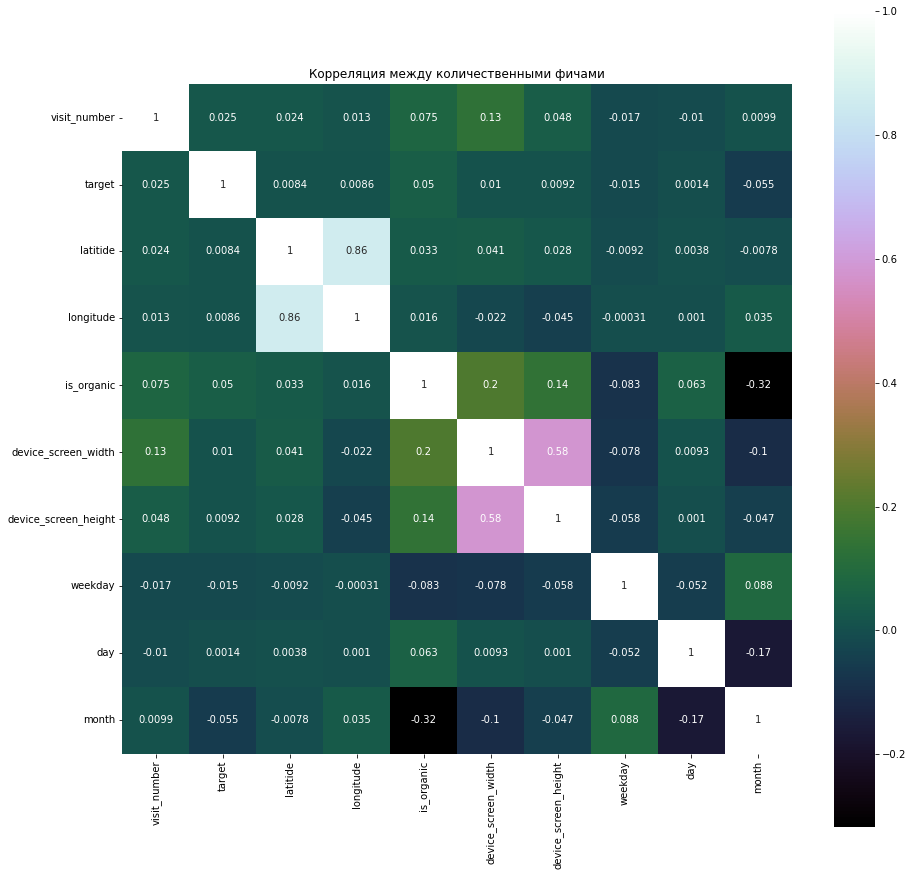

In [37]:
#построим тепловую карту корреляции
correlation = df_clean.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Корреляция между количественными фичами')
plt.show()

In [38]:
#Построим графики распределения количества сессий с целевым действием и сессий вцелом по разным фичам
def create_bar(df, param):
    tagg1 = df[df['target'] == 1].groupby([param], as_index=False)[['session_id']].count()
    tagg1 = tagg1.rename(columns={'session_id': 'count'})
    tagg2 = df.groupby([param], as_index=False)[['session_id']].count()
    tagg2 = tagg2.rename(columns={'session_id': 'count'})
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,12), sharey = False)
    ax1.bar(tagg1[param], tagg1['count'], color='green')
    
    ax1.set_xlabel(param)
    ax1.set_ylabel('Количество')
    ax1.set_title('Распределение параметра '+param+' для сессий с целевым действием')
    ax2.bar(tagg2[param], tagg2['count'], color='red')
    
    ax2.set_xlabel(param)
    ax2.set_ylabel('Количество')
    ax2.set_title('Распределение параметра '+param+' для всех сессий')
    
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    return plt;
    

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

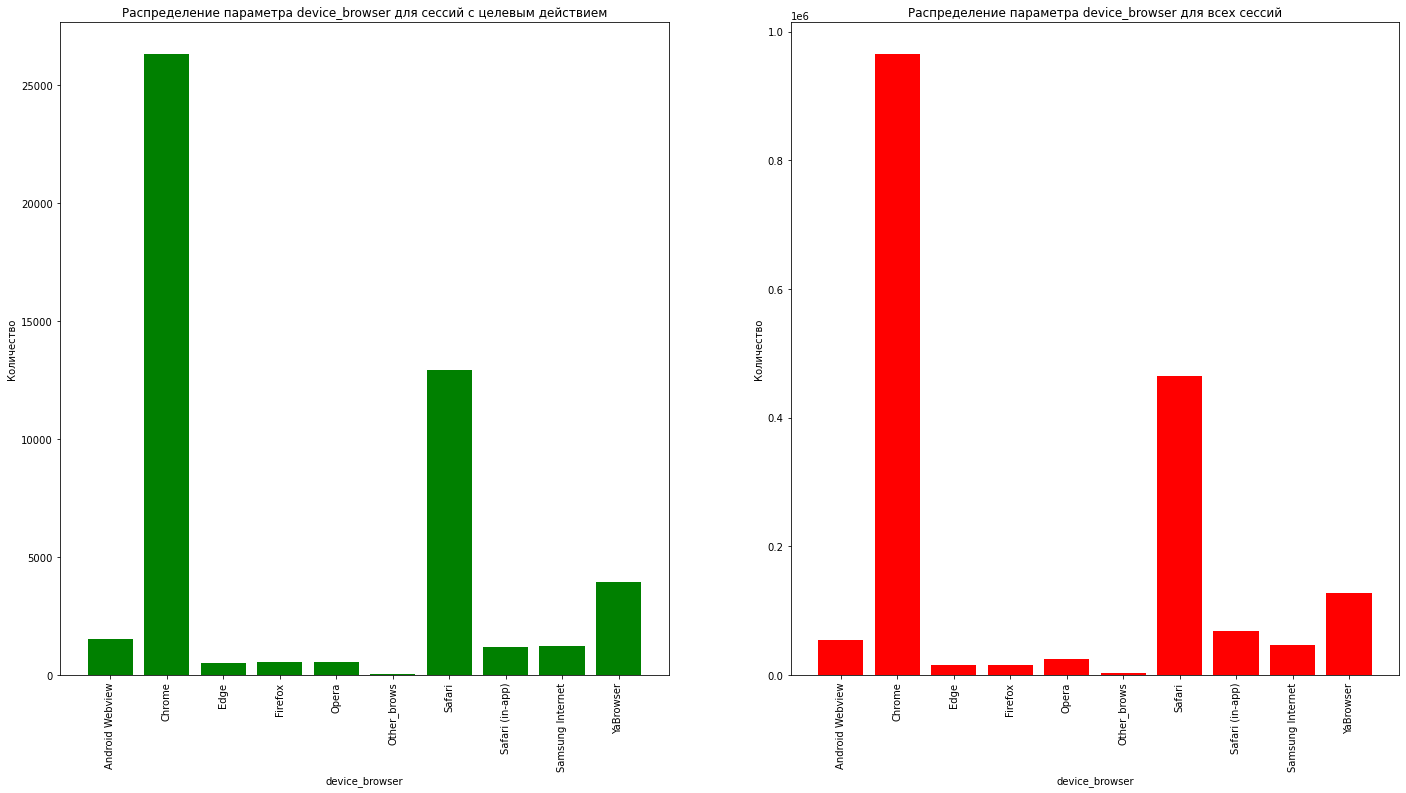

In [39]:
create_bar(df_clean, 'device_browser')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

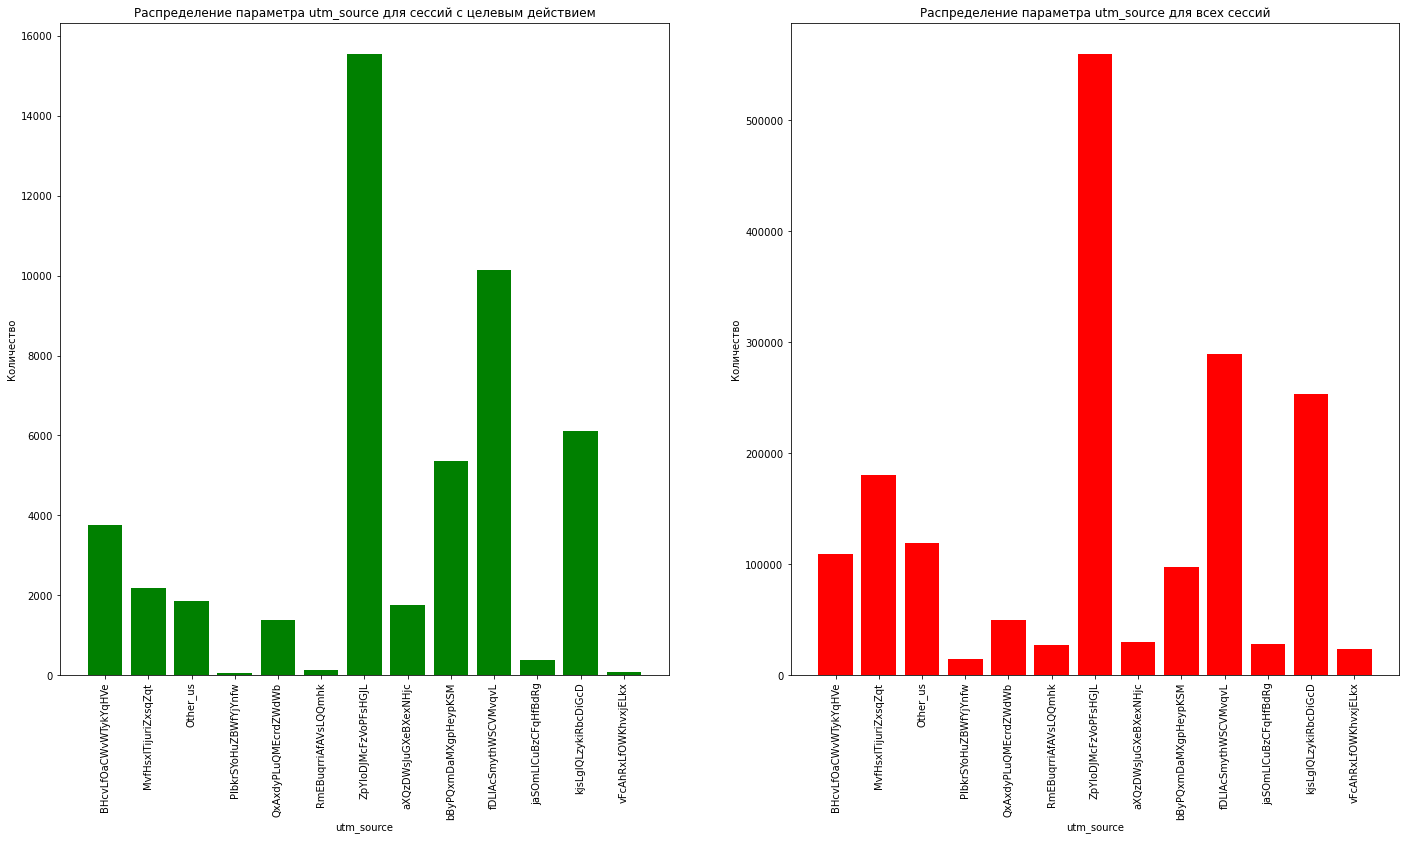

In [40]:
create_bar(df_clean, 'utm_source')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

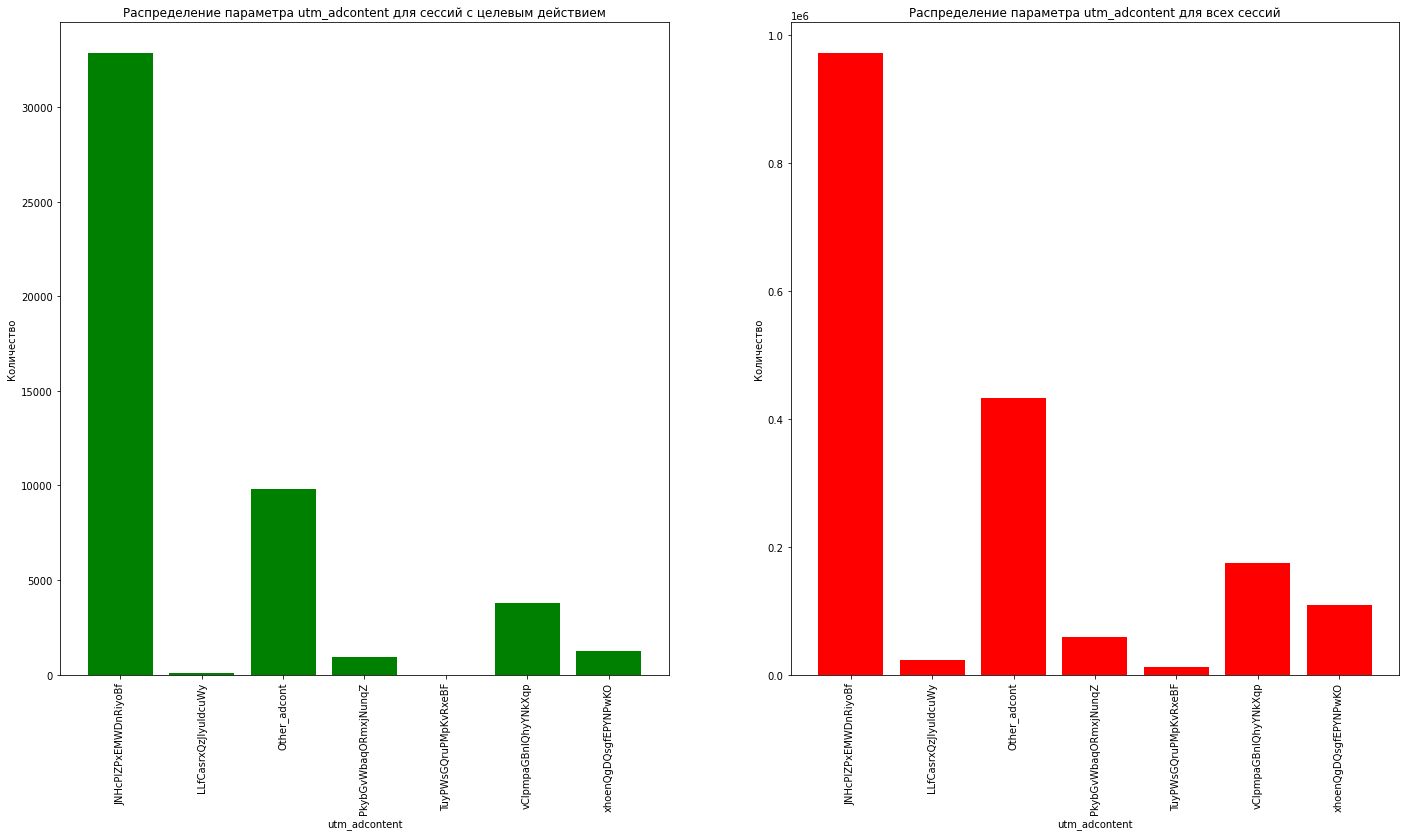

In [41]:
create_bar(df_clean, 'utm_adcontent')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

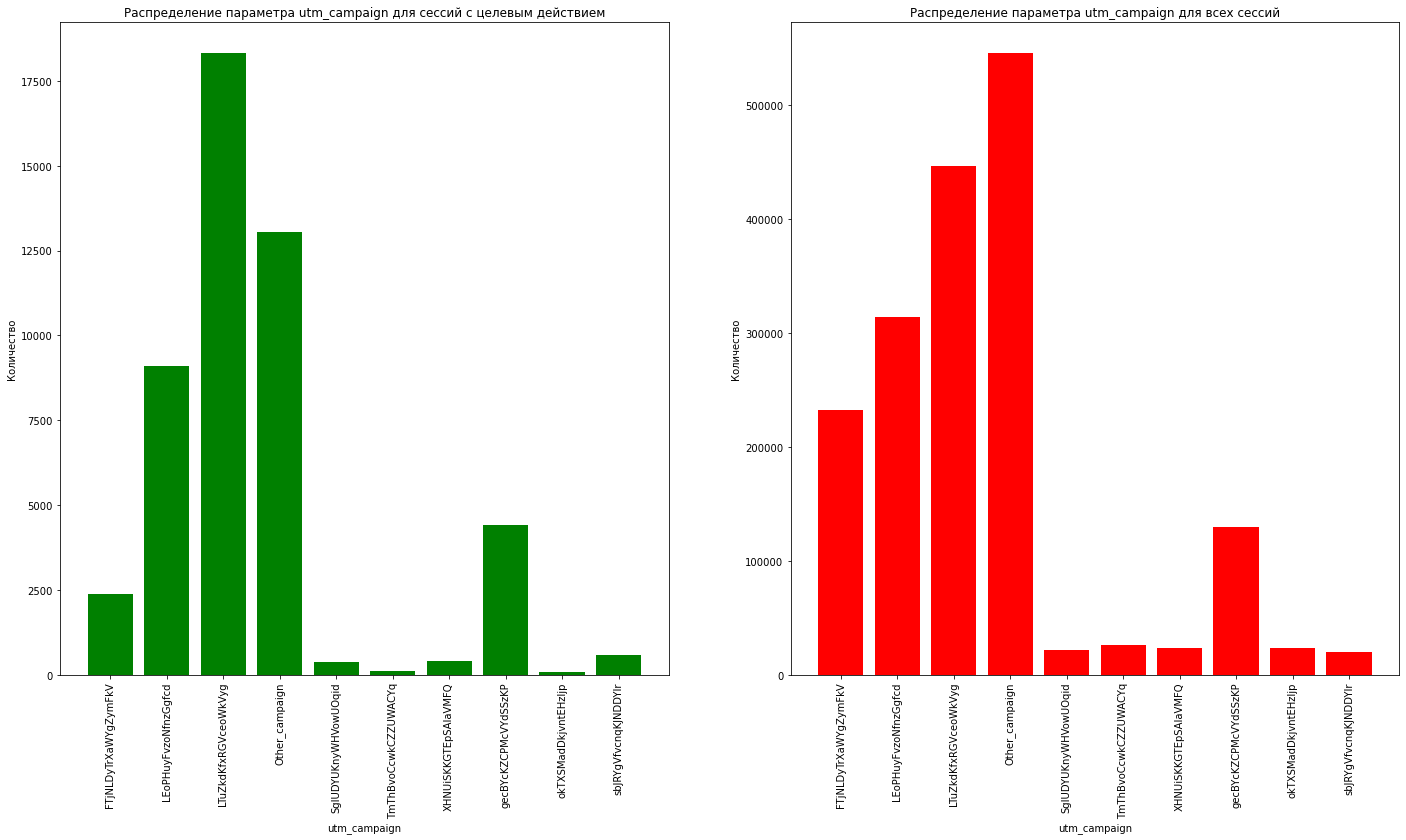

In [42]:
create_bar(df_clean, 'utm_campaign')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

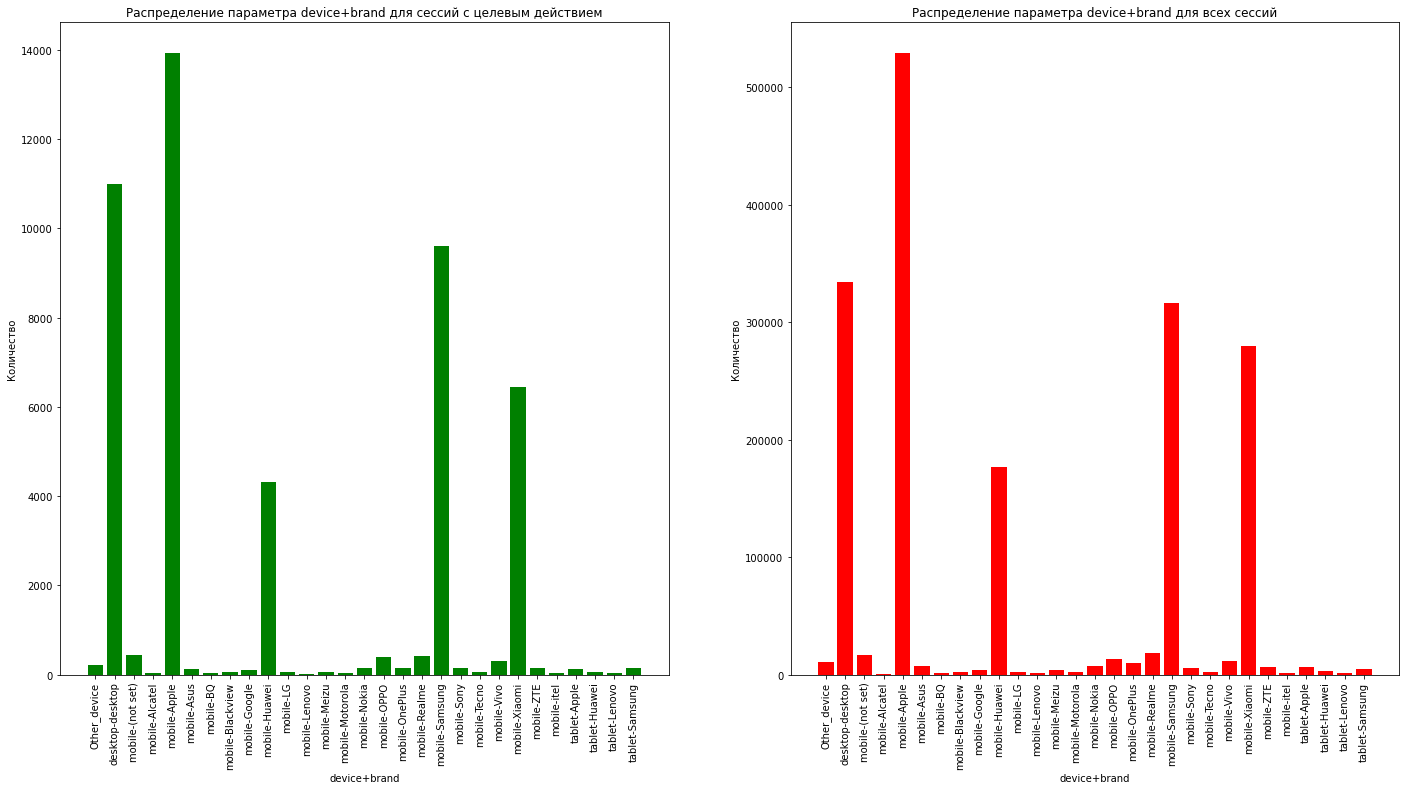

In [43]:
create_bar(df_clean, 'device+brand')

In [44]:
def create_plot(df, param):
    pagg1 = df[df['target'] == 1].groupby([param], as_index=False)[['session_id']].count()
    pagg1 = pagg1.rename(columns={'session_id': 'count'})
    pagg2 = df.groupby([param], as_index=False)[['session_id']].count()
    pagg2 = pagg2.rename(columns={'session_id': 'count'})
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,8), sharex = False)
    ax1.plot(pagg1[param], pagg1['count'], color='green')
    ax1.set_xlabel(param)
    ax1.set_ylabel('Количество')
    ax1.set_title('Распределение параметра '+param+' для сессий с целевым действием')
    ax2.plot(pagg2[param], pagg2['count'], color='red')
    ax2.set_xlabel(param)
    ax2.set_ylabel('Количество')
    ax2.set_title('Распределение параметра '+param+' для всех сессий')
    
    return plt;

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

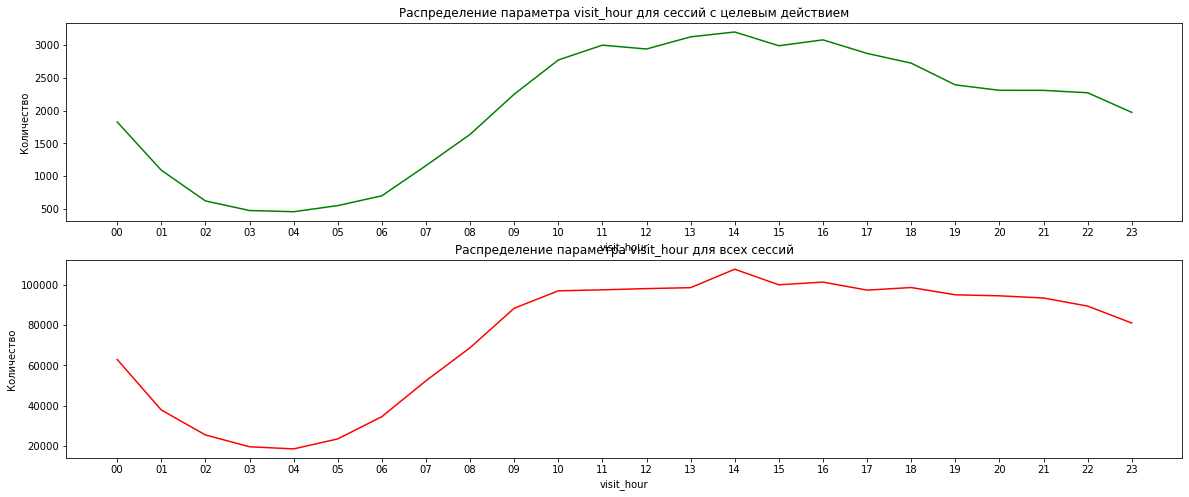

In [45]:
create_plot(df_clean, 'visit_hour')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

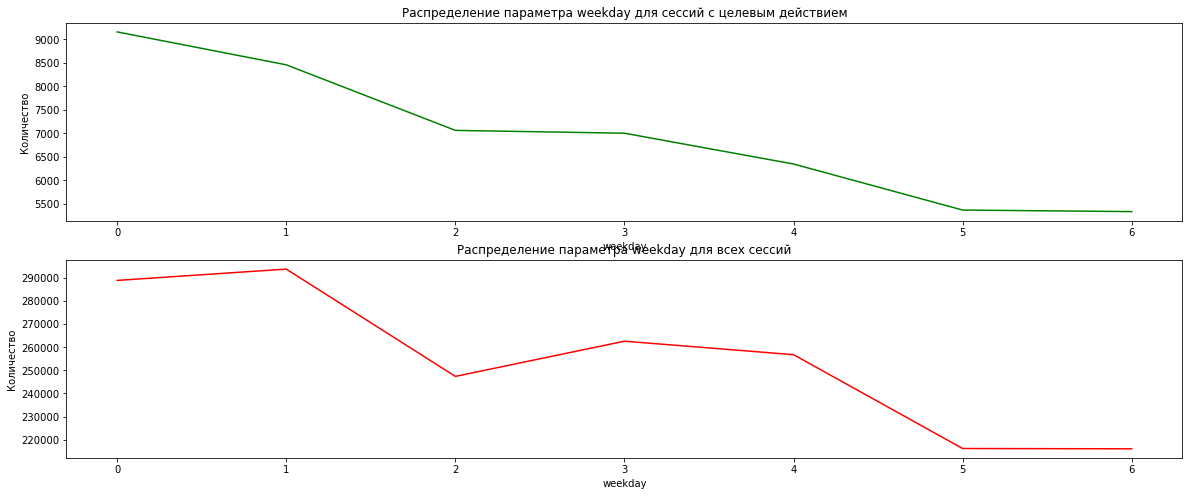

In [46]:
create_plot(df_clean, 'weekday')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

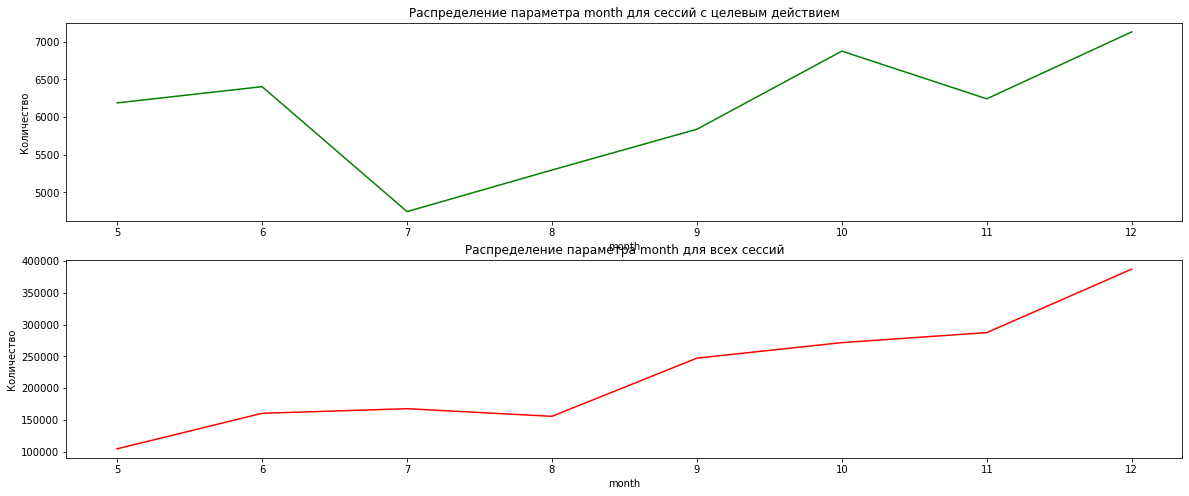

In [47]:
create_plot(df_clean, 'month')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

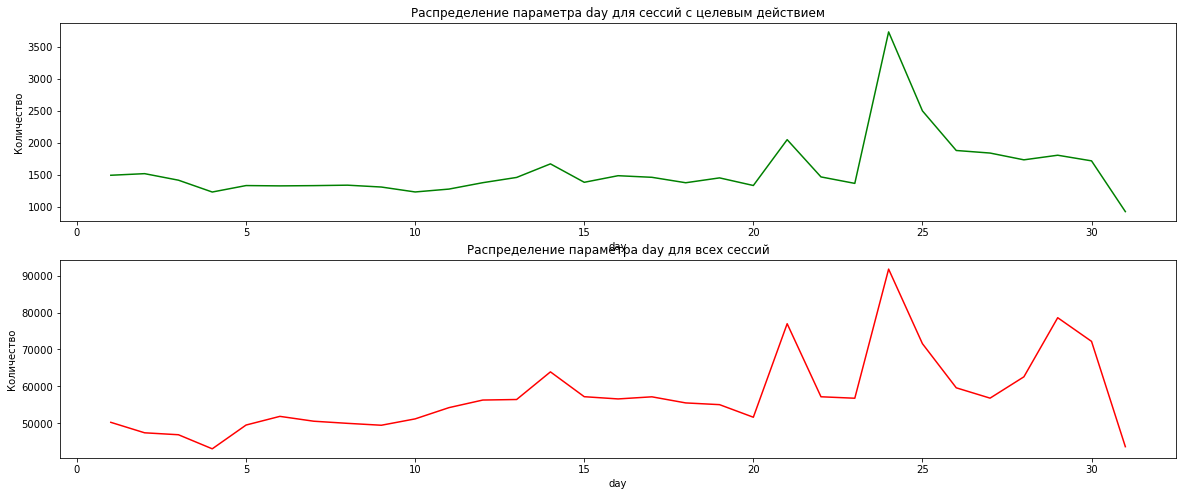

In [48]:
create_plot(df_clean, 'day')

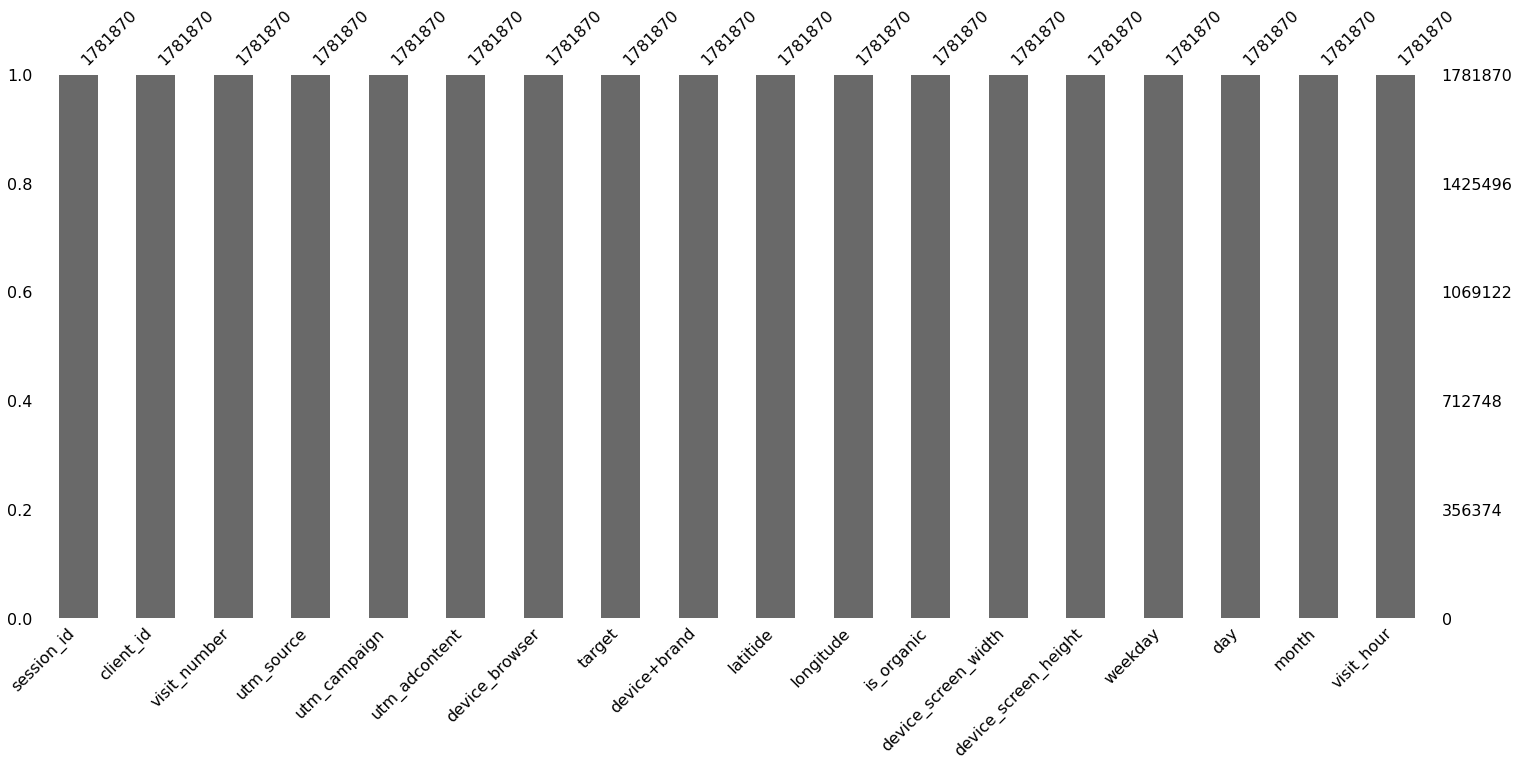

In [49]:
#контроль полноты заполнения параметров
msn.bar(df_clean);

In [50]:
df_clean.to_csv('data\ga_prepared.csv', index=False)
df_prepared = df_clean.copy()

# Modeling

In [51]:
#преобразуем категориальные фичи
ohe = OneHotEncoder(sparse=False)
category_list = ['device_browser', 'utm_source', 'utm_adcontent', 'utm_campaign', 'device+brand']

for item in category_list:
    ohe.fit(df_prepared[[item]])
    ohe_feature = ohe.transform(df_prepared[[item]])
    df_prepared[ohe.get_feature_names_out()] = ohe_feature
    df_prepared = df_prepared.drop(item, axis=1)
df_prepared.columns

Index(['session_id', 'client_id', 'visit_number', 'target', 'latitide',
       'longitude', 'is_organic', 'device_screen_width',
       'device_screen_height', 'weekday', 'day', 'month', 'visit_hour',
       'device_browser_Android Webview', 'device_browser_Chrome',
       'device_browser_Edge', 'device_browser_Firefox', 'device_browser_Opera',
       'device_browser_Other_brows', 'device_browser_Safari',
       'device_browser_Safari (in-app)', 'device_browser_Samsung Internet',
       'device_browser_YaBrowser', 'utm_source_BHcvLfOaCWvWTykYqHVe',
       'utm_source_MvfHsxITijuriZxsqZqt', 'utm_source_Other_us',
       'utm_source_PlbkrSYoHuZBWfYjYnfw', 'utm_source_QxAxdyPLuQMEcrdZWdWb',
       'utm_source_RmEBuqrriAfAVsLQQmhk', 'utm_source_ZpYIoDJMcFzVoPFsHGJL',
       'utm_source_aXQzDWsJuGXeBXexNHjc', 'utm_source_bByPQxmDaMXgpHeypKSM',
       'utm_source_fDLlAcSmythWSCVMvqvL', 'utm_source_jaSOmLICuBzCFqHfBdRg',
       'utm_source_kjsLglQLzykiRbcDiGcD', 'utm_source_vFcAhRxLfOWKhvxjEL

In [52]:
#нормализуем количественные фичи
std_scaler = StandardScaler()
std_scaler.fit(df_prepared[['visit_number', 'visit_hour', 'weekday', 'device_screen_width', 'device_screen_height', 'latitide', 'longitude', 'day', 'month']])
std_scaled = std_scaler.transform(df_prepared[['visit_number', 'visit_hour', 'weekday', 'device_screen_width', 'device_screen_height', 'latitide', 'longitude', 'day', 'month']])
df_prepared[['std_scaled_visit_number', 'std_scaled_visit_hour', 'std_scaled_weekday', 'std_scaled_device_screen_width', 'std_scaled_device_screen_height', 'std_scaled_latitide', 'std_scaled_longitude', 'std_scaled_day', 'std_scaled_month']] = std_scaled
df_prepared = df_prepared.drop(['visit_number', 'visit_hour', 'weekday', 'device_screen_width', 'device_screen_height', 'latitide', 'longitude', 'day', 'month'], axis=1)
df_prepared

,session_id,client_id,target,is_organic,device_browser_Android Webview,device_browser_Chrome,device_browser_Edge,device_browser_Firefox,device_browser_Opera,device_browser_Other_brows,...,device+brand_tablet-Samsung,std_scaled_visit_number,std_scaled_visit_hour,std_scaled_weekday,std_scaled_device_screen_width,std_scaled_device_screen_height,std_scaled_latitide,std_scaled_longitude,std_scaled_day,std_scaled_month
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,0.058554,-0.400834,-0.524390,-0.665903,0.481568,0.762378,0.798404,0.751018
1,905544597018549464.1636867290.1636867290,210838531.1636867288,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,-0.924933,1.615188,-0.478156,0.086228,0.534130,0.327797,-0.337977,0.751018
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,-1.908421,-0.904839,-0.524390,-0.665903,1.216852,1.499465,1.252956,1.205256
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,-1.416677,1.111182,-0.463361,-0.295451,0.534130,0.327797,1.366594,-1.974408
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.062243,-1.416677,1.111182,-0.463361,-0.295451,0.534130,0.327797,1.366594,-1.974408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,-0.597104,-0.400834,2.360646,1.354747,0.534130,0.327797,0.571127,1.205256
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,-0.924933,-0.400834,-0.468909,0.030098,-0.447383,0.442504,1.025680,-1.974408
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,0.222469,-1.408845,-0.496650,-0.963388,0.534130,0.327797,-0.224339,0.751018
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.145289,0.222469,-1.408845,-0.463361,0.069389,0.480885,0.796324,1.366594,0.751018


In [53]:
#формируем датасет для обучения и делим его на трейн и тест
x = df_prepared.drop(['session_id', 'client_id', 'target'], axis=1)
y = df_prepared['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape

((1247309, 79), (534561, 79))

In [54]:
#Случайный лес
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced', criterion='log_loss', n_estimators=300)
rf_clf.fit(x_train, y_train)
predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)
y_predict_proba = rf_clf.predict_proba(x_test)

print(roc_auc_score(y_test, y_predict_proba[:, 1]))
print(confusion_matrix(y_test, predicted_test_rf))


0.6442203127980438
[[513986   6122]
 [ 14025    428]]


In [55]:
f_imp_list = list(zip(x_train.columns, rf_clf.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)

f_imp_list

[('std_scaled_visit_hour', 0.18494652988574758),
 ('std_scaled_day', 0.13543156893793754),
 ('std_scaled_device_screen_height', 0.09622445670123049),
 ('std_scaled_weekday', 0.08263496055340208),
 ('std_scaled_longitude', 0.08232059176600444),
 ('std_scaled_latitide', 0.08136171072359938),
 ('std_scaled_month', 0.06323222899440838),
 ('std_scaled_device_screen_width', 0.05722296528962305),
 ('std_scaled_visit_number', 0.05391295966020147),
 ('device_browser_Chrome', 0.00917838178233244),
 ('device+brand_mobile-Xiaomi', 0.007237690459921177),
 ('device+brand_mobile-Samsung', 0.007177325577321364),
 ('device+brand_mobile-Huawei', 0.006545542276775011),
 ('utm_campaign_FTjNLDyTrXaWYgZymFkV', 0.0062683569787869535),
 ('device_browser_YaBrowser', 0.0059237650514329335),
 ('utm_adcontent_JNHcPlZPxEMWDnRiyoBf', 0.0058021803742039045),
 ('is_organic', 0.005593877539729298),
 ('device_browser_Safari', 0.005559674403179249),
 ('utm_source_bByPQxmDaMXgpHeypKSM', 0.004720062337187785),
 ('device+b

In [56]:
#логистическая регрессия
logreg = LogisticRegression(random_state=42, max_iter=600, solver='liblinear', class_weight='balanced')
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)
y_predict_proba = logreg.predict_proba(x_test)

print(roc_auc_score(y_test, y_predict_proba[:, 1]))
print(confusion_matrix(y_test, pred))


0.6648838116389466
[[299715 220393]
 [  5007   9446]]


In [78]:
cv_score = cross_validate(logreg, x, y, cv=4, scoring=["roc_auc", 'recall'], return_train_score=False)
cv_score


{'fit_time': array([45.25222445, 51.39021873, 40.80025959, 38.58710623]),
 'score_time': array([0.70658159, 0.77241945, 0.68776631, 0.63523841]),
 'test_roc_auc': array([0.66687295, 0.65829017, 0.66365064, 0.66422318]),
 'test_recall': array([0.66401248, 0.64119192, 0.65544701, 0.66464166])}

In [82]:
print(cv_score['test_roc_auc'].mean())
print(cv_score['test_recall'].mean())

0.6632592344857928
0.6563232656514256


In [57]:
f_imp_list_ll = list(zip(x_train.columns, logreg.coef_[0]))
f_imp_list_ll.sort(key = lambda x: x[1], reverse=True)

f_imp_list_ll

[('utm_campaign_okTXSMadDkjvntEHzIjp', 2.0661929355160153),
 ('utm_adcontent_PkybGvWbaqORmxjNunqZ', 1.810776974949683),
 ('utm_adcontent_xhoenQgDQsgfEPYNPwKO', 1.7764913855703512),
 ('is_organic', 0.8265138395262349),
 ('utm_source_QxAxdyPLuQMEcrdZWdWb', 0.7916383691111899),
 ('utm_source_BHcvLfOaCWvWTykYqHVe', 0.7007894676537405),
 ('device+brand_desktop-desktop', 0.5671622410949355),
 ('utm_adcontent_JNHcPlZPxEMWDnRiyoBf', 0.4762321193005114),
 ('device+brand_mobile-itel', 0.46158348747331507),
 ('device+brand_mobile-Alcatel', 0.4612117802035412),
 ('utm_source_aXQzDWsJuGXeBXexNHjc', 0.38644940770826514),
 ('utm_source_bByPQxmDaMXgpHeypKSM', 0.37632169744566746),
 ('utm_campaign_sbJRYgVfvcnqKJNDDYIr', 0.35839152786704215),
 ('device+brand_tablet-Lenovo', 0.35390631287571805),
 ('utm_source_ZpYIoDJMcFzVoPFsHGJL', 0.3068718466825692),
 ('utm_campaign_gecBYcKZCPMcVYdSSzKP', 0.2967574175060772),
 ('utm_adcontent_Other_adcont', 0.2907327350185564),
 ('utm_campaign_LEoPHuyFvzoNfnzGgfcd', 0

In [58]:
#многослойный персептрон 
mlp = MLPClassifier(random_state=42) 
mlp.fit(x_train, y_train)
pred_mlp = mlp.predict(x_test)
y_predict_proba = mlp.predict_proba(x_test)

print(roc_auc_score(y_test, y_predict_proba[:, 1]))
print(confusion_matrix(y_test, pred_mlp))


0.6932993297820733
[[520097     11]
 [ 14431     22]]


В качестве финальной модели выбираем логистическую регрессию, т.к. она позволяет выявить большее количество True Positive значений